In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import display
import itertools, time, os, pickle, json, tempfile, sys
srcpath = os.path.abspath(os.path.join(os.path.abspath(''),  '..',  'src'))
sys.path.append(srcpath)
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from exp_utils import *
#from data_gen_full import *
#%load_ext autoreload
%autoreload 2



plt.rcParams.update({
     "text.usetex" : "true",
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


plt.rc('figure', dpi=150)



```(relative, 0.05)``` implies $ R^{emp}(f_{N^*}) \approx 1 - (0.95)Acc(f^*) $ w.h.p


```(margin, 1) ``` implies  $ R^{emp}(f_{N^*}) \approx R_{1}^{emp}(f^*) $ w.h.p

In [140]:

with open('data_full_new.pkl', 'rb') as f:
    data = pickle.load(f)
    data = pd.DataFrame.from_dict(data, orient = 'index')
    data.index = pd.MultiIndex.from_tuples(data.index,  names=['kernel,dataset', 'm_train', 'm_test',
                                                               'C', 'N' ,'mode'])

#data
#data = data.sort_values(["m_train"])
#K = data.xs(("Havliscek","Generated"), level = 'kernel,dataset')['K_train'].iloc[0]
#eta_from_N(K, 2000, 0.1)
#N_from_eta(K, 0.492 )





In [288]:
acc = lambda x,y: 1 - np.mean(0.5*np.abs(x.flatten()-y.flatten()))
R_test = []
R_train = []
mode_list = []
test_acc = []
train_acc = []
for x in data.index:
  #  print(x)
    row =  data.loc[x]
    R_test.append(reliability(row["y_test_pred"], row["y_test_pred_random"]))
    R_train.append(reliability(row["y_train_pred"], row["y_train_pred_random"]))
    train_acc.append( acc(row["y_train"], row["y_train_pred"]) )
    test_acc.append( acc(row["y_test"], row["y_test_pred"]) )
data["R_train"] = R_train
data["R_test"] = R_test
data["Test Acc"] = test_acc
data["Train Acc"] = train_acc


In [293]:
data.columns

Index(['y_train', 'C_val', 'm_sv', 'K_train', 'y_test', 'K_test_train',
       'y_train_pred', 'y_test_pred', 'y_train_pred_random',
       'y_test_pred_random', 'R_train', 'R_test', 'Test Acc', 'Train Acc'],
      dtype='object')

/tmp/ipykernel_2515348/1603579208.py:19: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df = data.xs([key],level='kernel,dataset' ).reset_index()
/home/abhijith/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_2515348/1603579208.py:19: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df = data.xs([key],level='kernel,dataset' ).reset_index()
/home/abhijith/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_2515348/1603579208.py:19: FutureWarning: Passing lists as key for xs is dep

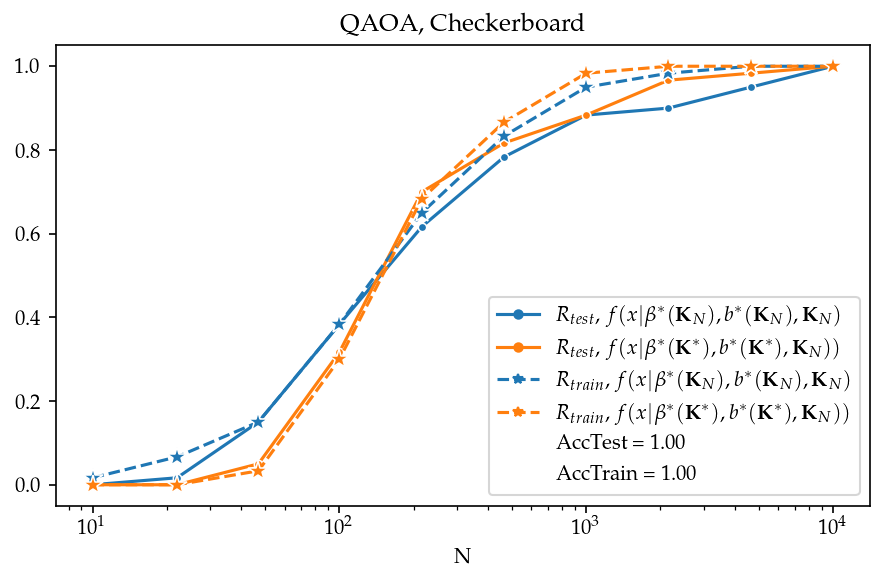

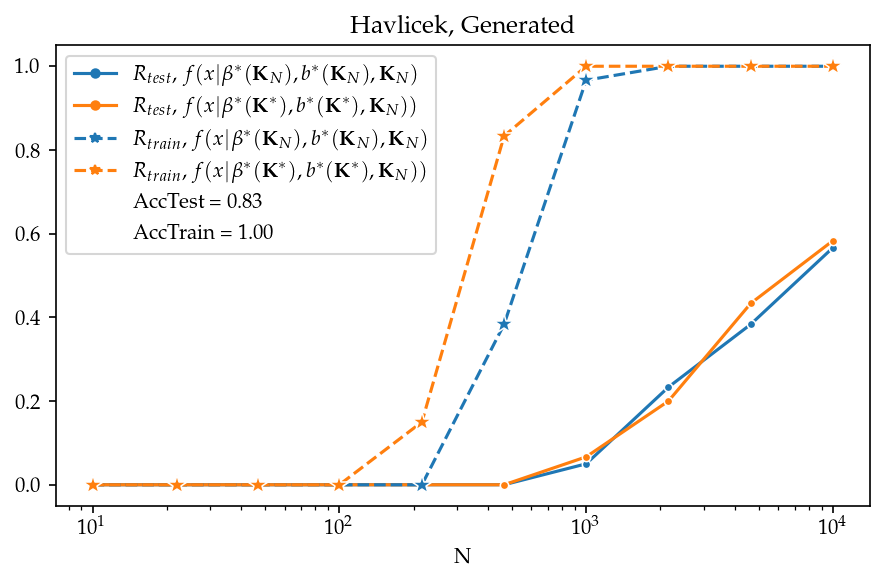

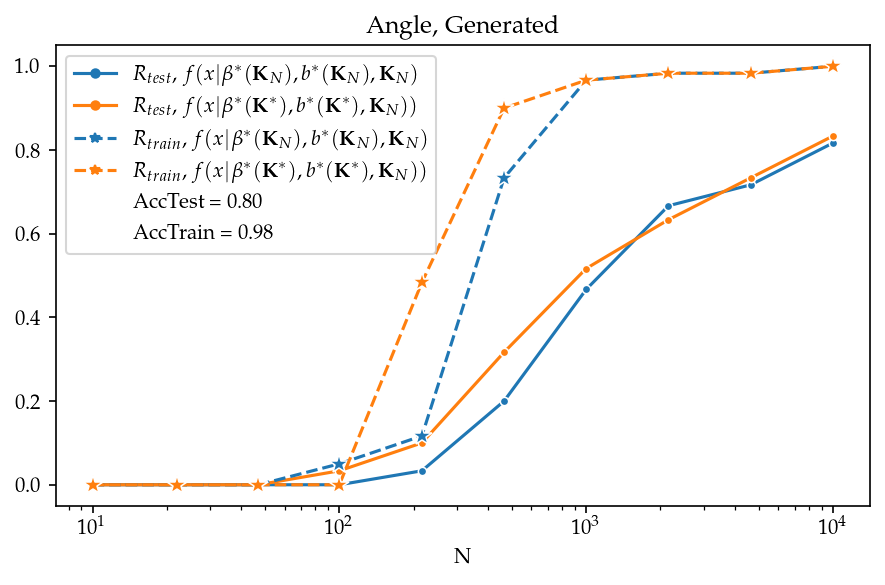

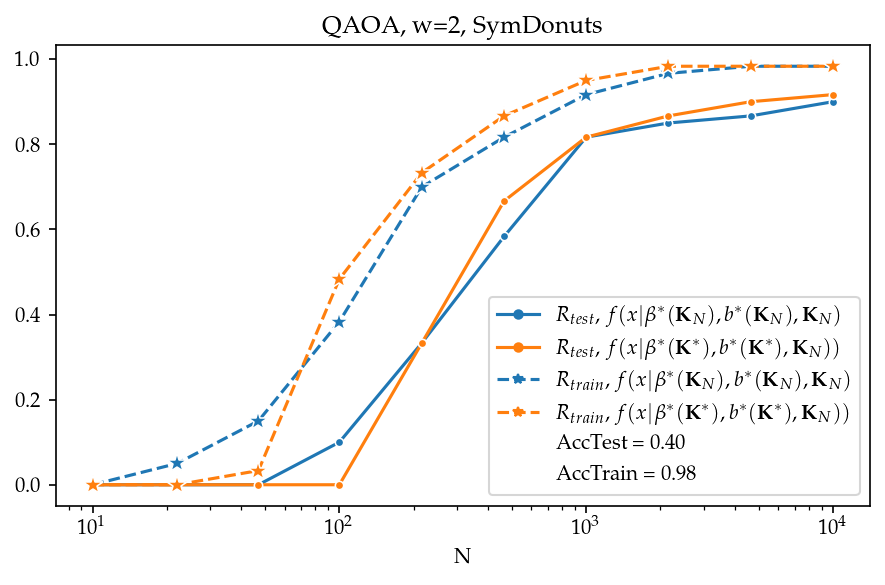

In [354]:
import matplotlib.lines as mlines
key_list = data.index.get_level_values("kernel,dataset").unique()
key = ('QAOA,2', 'SymDonuts')


#df.index.get_level_values("m_train").unique()
#names = data.index.names[1:]

def legend_mapper(x):
    if x == "test_train":
        return "$f(x| \\beta^*(\\mathbf{K}_N), b^*(\\mathbf{K}_N),\\mathbf{K}_N ) $"
    if x == "test_only":
        return "$f(x| \\beta^*(\\mathbf{K}^*),  b^*(\\mathbf{K}^*), \\mathbf{K}_N ))$"
    


def plot_key(key,ax):
    #print(data.columns)
    df = data.xs([key],level='kernel,dataset' ).reset_index()
    
    testacc = df["Test Acc"][0]
    trainacc = df["Train Acc"][0]
    df["mode"] = df["mode"].map(legend_mapper)
    sns.lineplot(data=df.rename({"R_test":"$R_{test}$"}, axis = 1), x = "N", y="$R_{test}$", 
             hue = "mode", marker = "o",markersize = 4,ax = ax)
    sns.lineplot(data=df.rename({"R_train":"$R_{train}$"}, axis = 1), x = "N", y="$R_{train}$", 
             hue = "mode", marker = "*", markersize = 10, ax= ax, linestyle="--")
   
    L = ax.legend()
   # return L

    L_test =  [mlines.Line2D([], [], color= L.get_lines()[i].get_color(), marker='o', linestyle='-',
                          markersize=4, label= "$R_{test}$,  " +  L.get_texts()[i].get_text()) for i in range(2)]

    L_train =  [mlines.Line2D([], [], color= L.get_lines()[i].get_color(), marker='*', linestyle='--',
                          markersize=5, label="$R_{train}$,  " +L.get_texts()[i].get_text()) for i in range(2,4)]
    
    L_testacc =  [mlines.Line2D([], [], color= L.get_lines()[i].get_color(), marker='', linestyle=' ',
                          markersize=5, label=f"AccTest = {testacc:.2f} " ) ] 
    L_trainacc =  [mlines.Line2D([], [], color= L.get_lines()[i].get_color(), marker='', linestyle=' ',
                          markersize=5, label=f"AccTrain = {trainacc:.2f} " ) ] 
    
    ax.legend( handles = L_test + L_train +  L_testacc + L_trainacc)
    ax.set_xscale("log")
    ax.set_ylabel("")
    kernel_key = key[0].replace("Havliscek",  "Havlicek")
    a = kernel_key.split(",")
    if len(a) == 2:
        a[0] =  a[0] + ", w=" + a[1] 
    ax.set_title(a[0].replace("_"," ") + ", " + key[1].replace("_"," ") )
    return a[0].replace("_"," ") + ", " + key[1].replace("_"," ")
    #plt.show()


selected_keylist = [('QAOA', 'Checkerboard'), ('Havliscek', 'Generated'),  ('Angle', 'Generated'), ('QAOA,2', 'SymDonuts') ]
for i,k in enumerate(selected_keylist):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    file_str = plot_key(k, ax)
    plt.tight_layout()
    fig.savefig( (file_str + "_ps.pdf").replace(" ","_"))

/tmp/ipykernel_2515348/1603579208.py:19: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df = data.xs([key],level='kernel,dataset' ).reset_index()
/home/abhijith/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_2515348/1603579208.py:19: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df = data.xs([key],level='kernel,dataset' ).reset_index()
/home/abhijith/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


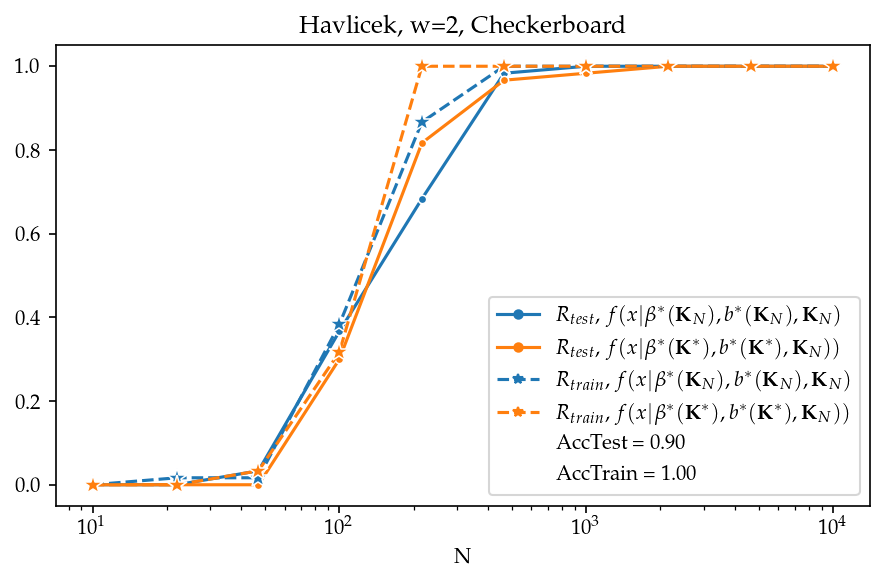

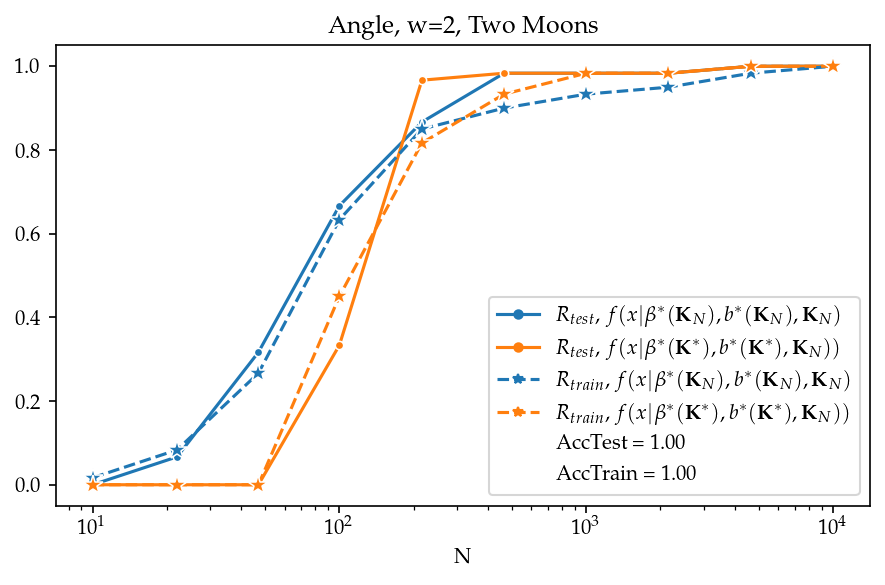

In [355]:
selected_keylist = [ ('Havliscek,2', 'Checkerboard'),('Angle,2', 'Two_Moons')]
for i,k in enumerate(selected_keylist):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    file_str = plot_key(k, ax)
    plt.tight_layout()
    plt.savefig( (file_str + "_ps.pdf").replace(" ","_"))
    

In [133]:
from exp_utils import *
#K,y = return_kernel(key, 120)
clf = SVC(kernel="precomputed", C = 1)
clf.fit(K,y)
y_pred =  np.sign(clf.decision_function(K))
N_trials = 100
N = 2000
y_pred_tensor = np.zeros((N_trials, 120))
for ind in range(N_trials):
    y_pred_tensor[ind,:] =  np.sign(clf.decision_function( kernel_estimate(K, N)))

In [137]:
reliability(y_pred, y_pred_tensor)

0.9583333333333334

In [3]:
#data.loc[:,[120],["optimal"]] ["N_vs_y_pred"][1]
data = data.rename_axis(index = lambda x: x.replace('_', ' ') if type(x)==str else x)
data =  data.rename(columns = lambda x: x.replace('_', ' ') if type(x)==str else x)
margin_err = []
N_star_margin = []
misclass_err = []
N_star_K = [] 
N_star_theorem = []
N_list = np.linspace(2,4000, 15, dtype=int)
for x in tqdm(data.index):
    #print(x)
    row = data.loc[x]
    margin_err.append( np.mean(row["y train"]*row["f pred exact"] < 1.0 - 1e-3) )
    misclass_err.append( np.mean(row["y train"]*row["f pred exact"]<0 ) ) 
    N_star_margin.append(N_star_from_df(row["N vs y pred"], margin_err[-1],row["y train"]))
    N_star_K.append(N_from_eta(row["K train"], 0.492))
    print(N_star_K[-1])
   
    N_star_theorem.append( 2*(row["C val"]**2)*row["m sv"]* np.log(x[1]/0.1) )
data["margin err"] = margin_err
data["misclass"] = misclass_err
data["N star margin"] = np.trunc(N_star_margin )
data["N_star_K"] =  np.trunc(N_star_K)
data["N star theorem"] = N_star_theorem
data = data.sort_values("misclass")



  0%|                                                                                                                                                                                         | 0/42 [00:00<?, ?it/s]

N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.475      -0.00833333 -0.04166667 -0.06666667 -0.075      -0.075
 -0.075      -0.08333333 -0.08333333 -0.08333333 -0.08333333 -0.08333333
 -0.08333333 -0.08333333 -0.08333333]
N vs Remp-Rstar


  2%|████▏                                                                                                                                                                            | 1/42 [00:17<11:59, 17.54s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.37009826e+01  3.65996675e-01  1.17032290e-01  9.13065799e-03
 -6.21598104e-02 -1.07484597e-01 -1.44085029e-01 -1.67822670e-01
 -1.89559918e-01 -2.09837939e-01]
1739.1253390382328
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.375 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ]
N vs Remp-Rstar


  5%|████████▍                                                                                                                                                                        | 2/42 [00:34<11:32, 17.31s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.41246090e+01  3.85710953e-01  1.31325399e-01  1.35825404e-02
 -5.81394468e-02 -1.02398630e-01 -1.22249348e-01 -1.63539031e-01
 -1.78225826e-01 -1.96199805e-01]
1773.1677139500632
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.43333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


  7%|████████████▋                                                                                                                                                                    | 3/42 [00:51<11:10, 17.20s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.44615981  0.39123116  0.13142407  0.02949093 -0.05252454 -0.09887631
 -0.13202895 -0.16082859 -0.18195147 -0.19802226]
1867.6854532824098
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.50833333  0.21666667  0.1         0.06666667  0.03333333  0.01666667
  0.00833333  0.00833333  0.          0.          0.         -0.00833333
 -0.00833333 -0.00833333 -0.00833333]
N vs Remp-Rstar


 10%|████████████████▊                                                                                                                                                                | 4/42 [01:08<10:50, 17.11s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.52032359e+01  4.38686478e-01  1.70534739e-01  4.58583200e-02
 -1.35167333e-02 -7.20472777e-02 -1.10271417e-01 -1.36350385e-01
 -1.63021829e-01 -1.83292353e-01]
2096.9116773946857
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.49166667  0.03333333  0.         -0.025      -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333]
N vs Remp-Rstar


 12%|█████████████████████                                                                                                                                                            | 5/42 [01:25<10:28, 16.99s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.28098962  0.39232927  0.1404595   0.01594178 -0.04933734 -0.07804655
 -0.12901848 -0.15708019 -0.1729227  -0.19486001]
1803.6176779264538
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
N vs Remp-Rstar


 14%|█████████████████████████▎                                                                                                                                                       | 6/42 [01:42<10:09, 16.92s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.38684704  0.39380096  0.12622126  0.01948502 -0.04829296 -0.09478097
 -0.13439476 -0.1431654  -0.1811776  -0.19353507]
1827.6489302819632
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.51666667  0.025      -0.01666667 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333]
N vs Remp-Rstar


 17%|█████████████████████████████▌                                                                                                                                                   | 7/42 [01:58<09:49, 16.85s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.37159565e+01  3.63770006e-01  9.77319565e-02 -4.54098795e-03
 -6.54561733e-02 -1.15203020e-01 -1.40568910e-01 -1.75105082e-01
 -1.93901720e-01 -2.03588107e-01]
1643.342824147077
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.53333333 0.10833333 0.03333333 0.025      0.00833333 0.00833333
 0.00833333 0.00833333 0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 19%|█████████████████████████████████▋                                                                                                                                               | 8/42 [02:15<09:30, 16.79s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.859794    0.46132797  0.17202554  0.05534192 -0.01695339 -0.07161881
 -0.11446588 -0.14068179 -0.16022141 -0.18062021]
2093.1066212598816
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.55833333 0.11666667 0.025      0.01666667 0.00833333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 21%|█████████████████████████████████████▉                                                                                                                                           | 9/42 [02:32<09:11, 16.72s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.16075816  0.43937624  0.16375963  0.04470866 -0.02668453 -0.0764
 -0.11027623 -0.13806504 -0.15506369 -0.17558932]
2015.767219881973
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.53333333 0.1        0.03333333 0.025      0.00833333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 24%|█████████████████████████████████████████▉                                                                                                                                      | 10/42 [02:48<08:53, 16.67s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.89595924  0.44031329  0.17579161  0.04405153 -0.02511956 -0.08074011
 -0.10609653 -0.1321187  -0.15489763 -0.18029199]
2021.6634022427081
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.50833333 0.35833333 0.28333333 0.31666667 0.23333333 0.225
 0.2        0.15833333 0.14166667 0.14166667 0.11666667 0.1
 0.10833333 0.125      0.10833333]
N vs Remp-Rstar


 26%|██████████████████████████████████████████████                                                                                                                                  | 11/42 [03:05<08:36, 16.66s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.50848617  0.41777796  0.14210039  0.03197336 -0.04165317 -0.09479232
 -0.12261922 -0.15280188 -0.17199958 -0.19271616]
1909.1613290049568
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.43333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 12/42 [03:22<08:20, 16.68s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.38179025e+01  3.47763434e-01  1.07124729e-01  5.08781010e-03
 -6.40112835e-02 -1.15469533e-01 -1.39676781e-01 -1.66285240e-01
 -1.91704227e-01 -2.10129078e-01]
1708.8895456625
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.5        0.3        0.25       0.2        0.175      0.13333333
 0.125      0.075      0.05833333 0.05       0.05       0.04166667
 0.03333333 0.01666667 0.025     ]
N vs Remp-Rstar


 31%|██████████████████████████████████████████████████████▍                                                                                                                         | 13/42 [03:38<08:03, 16.66s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.08941115  0.3978041   0.13748744  0.02821708 -0.03838858 -0.08827036
 -0.12216248 -0.15071028 -0.17531977 -0.19294168]
1903.2635424438213
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.49166667  0.04166667  0.         -0.00833333 -0.00833333 -0.00833333
 -0.00833333 -0.00833333 -0.00833333 -0.00833333 -0.00833333 -0.00833333
 -0.00833333 -0.00833333 -0.00833333]
N vs Remp-Rstar


 33%|██████████████████████████████████████████████████████████▋                                                                                                                     | 14/42 [03:55<07:46, 16.66s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.27879737  0.42424192  0.13805399  0.02394144 -0.04572744 -0.08978993
 -0.12938946 -0.14745045 -0.17331354 -0.18858186]
1858.8381558490892
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.34166667 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667
 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667
 -0.01666667 -0.01666667 -0.01666667]
N vs Remp-Rstar


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                 | 15/42 [04:12<07:29, 16.65s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.42949589e+01  4.07329687e-01  1.29624611e-01  1.08957839e-02
 -5.23198752e-02 -9.72537018e-02 -1.30675435e-01 -1.56243411e-01
 -1.70730331e-01 -1.98959707e-01]
1763.7166637386235
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.45833333  0.025       0.         -0.025      -0.025      -0.03333333
 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333]
N vs Remp-Rstar


 38%|███████████████████████████████████████████████████████████████████                                                                                                             | 16/42 [04:28<07:12, 16.62s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.34077465  0.3952766   0.13155097  0.02259443 -0.04529435 -0.09370727
 -0.13325572 -0.15699656 -0.17018348 -0.19530152]
1852.8234786788066
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.34166667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                        | 17/42 [04:45<06:55, 16.62s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.0524523   0.38879275  0.13226035  0.03225175 -0.0492636  -0.09415695
 -0.13679388 -0.15872195 -0.17480328 -0.1973165 ]
1887.7190377429013
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.21666667 -0.23333333 -0.23333333 -0.24166667 -0.24166667 -0.25
 -0.25       -0.24166667 -0.24166667 -0.25       -0.25       -0.25
 -0.25       -0.25       -0.25833333]
N vs Remp-Rstar


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 18/42 [05:01<06:38, 16.61s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.39266612  0.39459646  0.1501977   0.02058644 -0.04610944 -0.09684731
 -0.12655724 -0.154286   -0.18000353 -0.19762566]
1839.4099350056167
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
N vs Remp-Rstar


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 19/42 [05:18<06:21, 16.59s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.26733732  0.40510492  0.14207402  0.01489641 -0.05323953 -0.08967608
 -0.12332004 -0.1467841  -0.18546038 -0.19800772]
1789.4112928600894
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
N vs Remp-Rstar


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 20/42 [05:34<06:05, 16.60s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.393758    0.39594166  0.1321563   0.01999769 -0.04256826 -0.09049938
 -0.12835344 -0.15522893 -0.1817642  -0.19748805]
1845.4988710706853
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.34166667  0.025      -0.05833333 -0.11666667 -0.13333333 -0.175
 -0.175      -0.20833333 -0.20833333 -0.21666667 -0.21666667 -0.21666667
 -0.225      -0.225      -0.23333333]
N vs Remp-Rstar


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 21/42 [05:52<05:51, 16.74s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.41385331  0.40267448  0.13628495  0.02348716 -0.0374736  -0.08794373
 -0.12098654 -0.15898399 -0.17537057 -0.19437453]
1881.9606250280688
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.075      -0.34166667 -0.375      -0.36666667 -0.375      -0.375
 -0.375      -0.38333333 -0.375      -0.375      -0.375      -0.375
 -0.375      -0.38333333 -0.375     ]
N vs Remp-Rstar


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 22/42 [06:09<05:36, 16.84s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.34413535  0.39331599  0.15166272  0.02669549 -0.04095523 -0.08556322
 -0.12380332 -0.1571746  -0.17176745 -0.1943021 ]
1887.1387782669235
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.09166667 -0.35833333 -0.40833333 -0.425      -0.44166667 -0.44166667
 -0.44166667 -0.44166667 -0.44166667 -0.44166667 -0.45       -0.45
 -0.44166667 -0.44166667 -0.45      ]
N vs Remp-Rstar


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 23/42 [06:26<05:22, 16.99s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.19899017  0.46497112  0.16763301  0.04576975 -0.01763203 -0.07707392
 -0.10623963 -0.13805644 -0.15703947 -0.18384902]
2068.8951640575006
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.53333333 0.11666667 0.03333333 0.025      0.00833333 0.00833333
 0.00833333 0.00833333 0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 24/42 [06:43<05:04, 16.91s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.02889965  0.45047807  0.17474585  0.05471783 -0.02535404 -0.08065287
 -0.10636956 -0.13619082 -0.15804221 -0.18246173]
2047.4920094798044
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.05       -0.34166667 -0.36666667 -0.38333333 -0.40833333 -0.39166667
 -0.41666667 -0.425      -0.41666667 -0.41666667 -0.40833333 -0.41666667
 -0.41666667 -0.41666667 -0.41666667]
N vs Remp-Rstar


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25/42 [06:59<04:46, 16.83s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.02928256  0.41382128  0.14960603  0.03929731 -0.03059946 -0.0841209
 -0.11960742 -0.15092162 -0.16737607 -0.19248342]
1980.2191055284861
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.2        -0.25833333 -0.28333333 -0.3        -0.29166667 -0.3
 -0.3        -0.3        -0.3        -0.3        -0.3        -0.3
 -0.3        -0.3        -0.3       ]
N vs Remp-Rstar


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26/42 [07:16<04:29, 16.86s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.17309025  0.43466279  0.1825475   0.03729637 -0.02813735 -0.0699141
 -0.10665168 -0.13634382 -0.16457222 -0.17758575]
1984.5327732155047
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.55833333 0.1        0.05       0.025      0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 27/42 [07:33<04:13, 16.87s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.15531051  0.43364949  0.16710591  0.05458762 -0.02278733 -0.07975699
 -0.10915977 -0.13827568 -0.15944618 -0.18467583]
2059.7847372972565
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.28333333  0.025      -0.03333333 -0.11666667 -0.13333333 -0.13333333
 -0.175      -0.175      -0.175      -0.175      -0.18333333 -0.18333333
 -0.19166667 -0.19166667 -0.2       ]
N vs Remp-Rstar


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28/42 [07:50<03:57, 16.93s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.52511152  0.39448126  0.14105463  0.03423029 -0.05294097 -0.08060186
 -0.12283515 -0.1520934  -0.16573245 -0.19027846]
1886.067499294659
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.34166667 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667
 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667 -0.01666667
 -0.01666667 -0.01666667 -0.01666667]
N vs Remp-Rstar


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 29/42 [08:07<03:39, 16.90s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.34105916  0.39747153  0.13421149  0.0156794  -0.05502204 -0.09684872
 -0.13321825 -0.15181547 -0.17645565 -0.19893809]
1791.1558202885976
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
N vs Remp-Rstar


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 30/42 [08:25<03:24, 17.07s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.36981793  0.41254716  0.13491802  0.0282546  -0.05359033 -0.09383732
 -0.13296563 -0.15421777 -0.1804617  -0.19620424]
1859.712811112028
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.15833333 -0.29166667 -0.3        -0.30833333 -0.30833333 -0.30833333
 -0.30833333 -0.30833333 -0.30833333 -0.30833333 -0.30833333 -0.30833333
 -0.30833333 -0.30833333 -0.30833333]
N vs Remp-Rstar


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 31/42 [08:41<03:07, 17.04s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.36972660e+01  3.55774088e-01  1.19959930e-01  1.08807816e-02
 -6.20039225e-02 -9.08890786e-02 -1.43121093e-01 -1.71091632e-01
 -1.89592096e-01 -2.07843710e-01]
1750.9043730627343
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.44166667  0.         -0.03333333 -0.05       -0.05833333 -0.06666667
 -0.075      -0.075      -0.075      -0.06666667 -0.075      -0.075
 -0.075      -0.075      -0.075     ]
N vs Remp-Rstar


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 32/42 [08:58<02:49, 16.93s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.39074684e+01  3.66141907e-01  1.22758799e-01  2.29196529e-03
 -5.75377400e-02 -1.03158190e-01 -1.41702192e-01 -1.71625765e-01
 -1.90369158e-01 -2.03501626e-01]
1689.273792276763
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.28333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333]
N vs Remp-Rstar


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 33/42 [09:15<02:31, 16.84s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.454272    0.40104406  0.14389164  0.02746546 -0.03320059 -0.09166202
 -0.11839686 -0.1510017  -0.17266243 -0.19347012]
1919.4171649630193
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.30833333 -0.08333333 -0.08333333 -0.08333333 -0.08333333 -0.08333333
 -0.08333333 -0.08333333 -0.08333333 -0.08333333 -0.08333333 -0.08333333
 -0.08333333 -0.08333333 -0.08333333]
N vs Remp-Rstar


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 34/42 [09:31<02:14, 16.79s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.36077571e+01  3.53818619e-01  1.01142809e-01 -5.26153514e-03
 -6.59231437e-02 -1.12479082e-01 -1.39929236e-01 -1.61391751e-01
 -1.88860513e-01 -2.08875920e-01]
1640.539600057894
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.48333333  0.03333333  0.         -0.00833333 -0.00833333 -0.00833333
 -0.00833333 -0.00833333 -0.00833333 -0.00833333 -0.00833333 -0.00833333
 -0.00833333 -0.00833333 -0.00833333]
N vs Remp-Rstar


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 35/42 [09:48<01:57, 16.72s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.41057672  0.39927981  0.13291122  0.0275823  -0.04225428 -0.09266564
 -0.11937706 -0.14939445 -0.17155555 -0.18856866]
1887.3316349506765
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.45       0.00833333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 36/42 [10:05<01:40, 16.70s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.35474900e+01  3.48423578e-01  1.15128601e-01  3.96251010e-04
 -6.93075412e-02 -1.08651556e-01 -1.39808753e-01 -1.72286835e-01
 -1.89656318e-01 -2.11404233e-01]
1671.1569501075987
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.45833333  0.01666667 -0.01666667 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333 -0.03333333
 -0.03333333 -0.03333333 -0.03333333]
N vs Remp-Rstar


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 37/42 [10:22<01:23, 16.76s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.34887676e+01  3.40708301e-01  9.79350726e-02 -6.59123384e-03
 -6.87430418e-02 -1.11978316e-01 -1.47205934e-01 -1.72510832e-01
 -2.02202365e-01 -2.12288648e-01]
1632.981716241607
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.2        -0.25833333 -0.3        -0.31666667 -0.31666667 -0.325
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333]
N vs Remp-Rstar


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 38/42 [10:38<01:07, 16.81s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.05713183  0.44417136  0.17172598  0.05899577 -0.02039263 -0.06298599
 -0.10622286 -0.14055957 -0.16286727 -0.18304533]
2080.6839572628182
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.26666667 -0.175      -0.175      -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333]
N vs Remp-Rstar


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 39/42 [10:55<00:50, 16.82s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[ 1.33843299e+01  3.63254837e-01  1.01869649e-01  1.48279899e-03
 -6.82656361e-02 -1.17196047e-01 -1.47279528e-01 -1.71186955e-01
 -1.91773622e-01 -2.07285452e-01]
1679.8059667223076
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[0.55       0.11666667 0.05       0.01666667 0.00833333 0.00833333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
N vs Remp-Rstar


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 40/42 [11:12<00:33, 16.78s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.9709704   0.44461147  0.16977982  0.04923328 -0.02510161 -0.07556997
 -0.1060181  -0.13366346 -0.15810014 -0.17935257]
2035.806856785664
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.50833333  0.2         0.10833333  0.06666667  0.04166667  0.025
  0.00833333  0.          0.          0.         -0.00833333 -0.00833333
 -0.00833333 -0.00833333 -0.00833333]
N vs Remp-Rstar


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 41/42 [11:29<00:16, 16.77s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[15.19262918  0.43932173  0.16393516  0.04962012 -0.02813799 -0.06574366
 -0.10848405 -0.14227077 -0.16188714 -0.17884618]
2022.3772535594405
N vs Remp-Rstar
[   2  287  573  858 1144 1429 1715 2001 2286 2572 2857 3143 3428 3714
 4000]
[ 0.075      -0.34166667 -0.38333333 -0.38333333 -0.4        -0.39166667
 -0.4        -0.40833333 -0.4        -0.40833333 -0.40833333 -0.41666667
 -0.41666667 -0.41666667 -0.425     ]
N vs Remp-Rstar


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [11:46<00:00, 16.82s/it]

[2.00000000e+00 5.57333333e+02 1.11266667e+03 1.66800000e+03
 2.22333333e+03 2.77866667e+03 3.33400000e+03 3.88933333e+03
 4.44466667e+03 5.00000000e+03]
[14.91936771  0.43812032  0.16633876  0.04593574 -0.02195115 -0.07585573
 -0.1167307  -0.13083939 -0.15480577 -0.18346252]
2043.7668989137128


N vs y pred  \
kernel,dataset              m train C                                                            
(QAOA, Checkerboard)        120     optimal                                                ...   
(Havliscek, Generated)      120     1                                                      ...   
(Angle, Generated)          120     4                                                      ...   
(Havliscek, Generated)      120     4                                                      ...   
(Circ-Hubr,2, Two_Moons)    120     1                                                      ...   
                                    4                                                      ...   
(QAOA, Checkerboard)        120     1                                                      ...   
                                    4                                                      ...   
(QAOA,2, Checkerboard)      120     1                                                      ...   
(QAOA, Two_Moons)           120     1                                                      ...   
(QAOA,2, Checkerboard)      120     4                                                      ...   
(QAOA, Two_Moons)           120     4                                                      ...   
(Angle,2, Two_Moons)        120     4                                                      ...   
(QAOA, Generated)           120     1                                                      ...   
(Angle,2, Two_Moons)        120     1                                                      ...   
(QAOA, Generated)           120     4                                                      ...   
(Circ-Hubr, Generated)      120     4                                                      ...   
(QAOA,2, Two_Moons)         120     4                                                      ...   
(Circ-Hubr,2, Checkerboard) 120     4                                                      ...   
(Havliscek,2, Checkerboard) 120     1                                                      ...   
(Havliscek,2, Two_Moons)    120     optimal                                                ...   
(Circ-Hubr,2, Two_Moons)    120     optimal                                                ...   
(Circ-Hubr, Generated)      120     optimal                                                ...   
(Havliscek,2, Checkerboard) 120     optimal                                                ...   
(QAOA,2, Two_Moons)         120     optimal                                                ...   
(Angle,2, Two_Moons)        120     optimal                                                ...   
(Angle, Generated)          120     optimal                                                ...   
(QAOA, Generated)           120     optimal                                                ...   
(Havliscek, Generated)      120     optimal                                                ...   
(QAOA,2, Two_Moons)         120     1                                                      ...   
(QAOA,2, SymDonuts)         120     optimal                                                ...   
(Circ-Hubr,2, Checkerboard) 120     optimal                                                ...   
(QAOA,2, Checkerboard)      120     optimal                                                ...   
(Havliscek,2, Two_Moons)    120     1                                                      ...   
(Havliscek,2, Checkerboard) 120     4                                                      ...   
(Havliscek,2, Two_Moons)    120     4                                                      ...   
(QAOA, Two_Moons)           120     optimal                                                ...   
(Angle, Generated)          120     1                                                      ...   
(Circ-Hubr, Generated)      120     1                                                      ...   
(QAOA,2, SymDonuts)         120     4                            

In [25]:
df = data[data["N star margin"] > 2]
df = data[data["margin err"] < 0.15]


df = df[["C val", "m sv", "margin err", "N star margin",  "N star theorem", "N_star_K"]]
df.xs(1, level="C").sort_values("m sv")


,,C val,m sv,margin err,N star margin,N star theorem,N_star_K
"kernel,dataset",m train,,,,,,
"(QAOA, Two_Moons)",120,1.0,21,0.083333,226.0,297.783227,1715.0
"(Havliscek,2, Two_Moons)",120,1.0,21,0.016667,273.0,297.783227,1859.0
"(Circ-Hubr,2, Two_Moons)",120,1.0,25,0.016667,273.0,354.503842,1842.0
"(QAOA,2, Two_Moons)",120,1.0,30,0.000000,287.0,425.404610,1862.0


In [26]:
df = data[data["N star margin"] > 2]
df = data[data["margin err"] < 0.15]

df = data[["C val", "m sv", "margin err", "N star margin",  "N star theorem", "N_star_K"]]
df.xs("optimal", level="C").sort_values("m sv")


,,C val,m sv,margin err,N star margin,N star theorem,N_star_K
"kernel,dataset",m train,,,,,,
"(QAOA, Two_Moons)",120,4.089796,12,0.000000,287.0,2846.200285,1641.0
"(Angle,2, Two_Moons)",120,4.089796,16,0.033333,458.0,3794.933713,1650.0
"(QAOA, Checkerboard)",120,4.089796,20,0.083333,282.0,4743.667141,1752.0
"(Circ-Hubr,2, Two_Moons)",120,4.089796,21,0.000000,287.0,4980.850498,1807.0
"(Havliscek,2, Two_Moons)",120,4.089796,22,0.000000,287.0,5218.033855,1830.0
"(Circ-Hubr,2, Checkerboard)",120,12.252721,24,0.041667,4000.0,51092.514214,1940.0
"(QAOA,2, Checkerboard)",120,4.089796,24,0.008333,573.0,5692.400569,1847.0
"(Havliscek,2, Checkerboard)",120,4.089796,25,0.033333,573.0,5929.583926,1860.0
"(QAOA,2, Two_Moons)",120,4.089796,29,0.000000,287.0,6878.317354,1846.0


In [28]:
20*16*np.log(120)

1531.9973576902546

In [13]:
#idx_c = [x for x in data.index if x[0][1] == "Checkerboard"]
#data.loc[idx_c]

In [14]:

data = data[data["N star margin"] > 2]
df = data[["C val", "margin err", "misclass", "N star margin"  ] ].sort_values("margin err")
Kerr_list = []
N_star_Kerr = []

for x in df.index:
    f =  interp1d(N_list, data.loc[x]["Kerror vs. N"])
    Kerr_list.append(f(df.loc[x]["N star margin"]) )
    model = LinearRegression()
    model.fit(np.log(data.loc[x]["Kerror vs. N"]).reshape(-1,1) , np.log(N_list))
    N_star_Kerr.append(np.exp( model.predict( np.log(data.loc[x]["margin err"]).reshape(1,-1) ) )[0] )
df["Kerr (N_star)"] = np.around(Kerr_list, 4)
df["Kerr/Margin_err"] = df["Kerr (N_star)"]/df["margin err"]
df["N star K err(extrapolated) "] = np.trunc(N_star_Kerr)
df

/tmp/ipykernel_2148487/3607129038.py:11: RuntimeWarning: divide by zero encountered in log
  N_star_Kerr.append(np.exp( model.predict( np.log(data.loc[x]["margin err"]).reshape(1,-1) ) )[0] )


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [166]:
model.fit(np.log(N_list).reshape(-1,1),  np.log(data.loc[x]["Kerror vs. N"]))

LinearRegression()

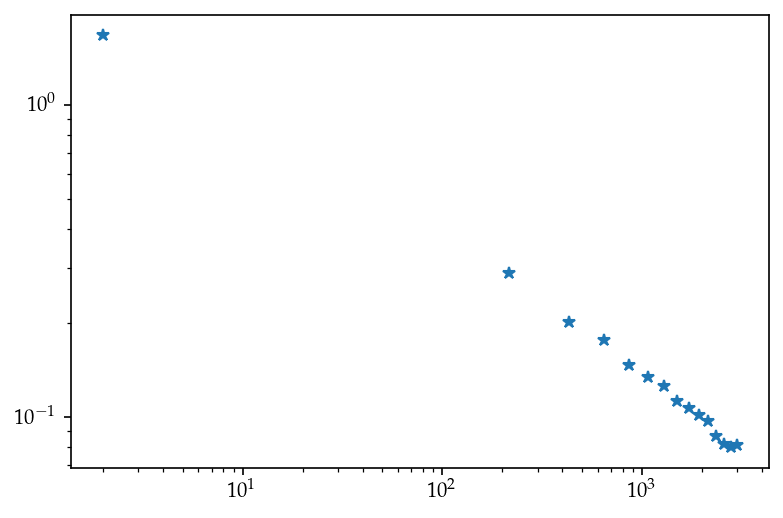

In [156]:
plt.plot(np.linspace(2,3000, 15, dtype=int),  data.iloc[1]["Kerror vs. N"], "*")
plt.xscale("log")
plt.yscale("log")

In [110]:
##Compute margin error and miscalssifications
#data["f pred exact"] = exact_y_pred
margin_err = []
N_star_margin = []
misclass_err = []
for x in tqdm(data.index):
    row = data.loc[x]
    print((row["y train"]*row["f pred exact"]).shape)
    margin_err.append( np.mean(row["y train"]*row["f pred exact"] < 1.0 - 1e-3) )
    misclass_err.append( np.mean(row["y train"]*row["f pred exact"]<0 ) ) 
    N_star_margin.append(N_star_from_df(row["N vs y pred"], margin_err[-1],row["y train"]))
data["margin err"] = margin_err
data["misclass"] = misclass_err
data["N star margin"] = N_star_margin 

  0%|          | 0/40 [00:00<?, ?it/s]

(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[ 0.38333333 -0.03333333 -0.05833333 -0.06666667 -0.06666667 -0.06666667
 -0.06666667 -0.06666667 -0.06666667 -0.06666667 -0.06666667 -0.06666667
 -0.06666667 -0.06666667 -0.06666667]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[ 0.175      -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333 -0.18333333
 -0.18333333 -0.18333333 -0.18333333]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[ 0.13333333 -0.24166667 -0.24166667 -0.24166667 -0.24166667 -0.24166667
 -0.24166667 -0.24166667 -0.25       -0.24166667 -0.25       -0.25
 -0.25       -0.25       -0.25      ]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[ 0.35833333 -0.05833333 -0.10833333 -0.13333333 -

[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[-0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667
 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667
 -0.36666667 -0.36666667 -0.36666667]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[-0.38333333 -0.38333333 -0.38333333 -0.38333333 -0.38333333 -0.38333333
 -0.38333333 -0.38333333 -0.38333333 -0.38333333 -0.38333333 -0.38333333
 -0.38333333 -0.38333333 -0.38333333]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[-0.375 -0.375 -0.375 -0.375 -0.375 -0.375 -0.375 -0.375 -0.375 -0.375
 -0.375 -0.375 -0.375 -0.375 -0.375]
(120,)
N vs Remp-Rstar
[   2  216  430  644  858 1072 1286 1501 1715 1929 2143 2357 2571 2785
 3000]
[-0.35833333 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667
 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.36666667 -0.366666

,,,N vs y pred,f pred exact,y train,C val,margin err,misclass,N star margin,Kerror vs. N
"kernel,dataset",m train,C,,,,,,,,
"(QAOA,2, Two_Moons)",120,optimal,...,"[-1.0195259485855273, 0.9955891578850797, 0.99...","[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -...",2.251361,0.066667,0.000000,198.880000,"[1.9543490846393672, 0.28012750816352594, 0.20..."
"(Circ-Hubr,2, Two_Moons)",120,optimal,...,"[-1.0673709225756076, 1.0001299164674005, 1.00...","[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -...",0.620068,0.183333,0.000000,106.511628,"[1.9390283435663676, 0.2781144577794555, 0.209..."
"(Havliscek,2, Two_Moons)",120,optimal,...,"[-1.0370726468849878, 1.062008341292845, 1.045...","[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -...",0.620068,0.250000,0.000000,78.088889,"[1.9548007344420721, 0.27720839257046137, 0.19..."
"(Angle,2, Two_Moons)",120,optimal,...,"[-1.1381286818326026, 1.0051789074222017, 0.99...","[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -...",2.659184,0.150000,0.000000,186.040000,"[1.9334529846692656, 0.2777506917410889, 0.205..."
"(Angle, Generated)",120,optimal,...,"[0.9996068622092524, 1.0407913472043282, 0.999...","[1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1...",2.047449,0.050000,0.000000,430.000000,"[1.7997946596116192, 0.28319957370188126, 0.20..."
"(Circ-Hubr, Generated)",120,optimal,...,"[0.9997396271680881, -0.9996850016718264, -1.8...","[1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",2.251361,0.125000,0.000000,399.428571,"[1.6151040538590484, 0.3167670948813982, 0.216..."
"(Havliscek, Generated)",120,optimal,...,"[-1.0003006489389001, -0.9999717994260411, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0,...",1.435714,0.100000,0.000000,311.111111,"[1.2334897263117666, 0.29001759501739, 0.20969..."
"(QAOA, Generated)",120,optimal,...,"[-0.9998374562500818, -0.9999496223682, -1.000...","[-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, ...",1.231803,0.250000,0.000000,138.595745,"[1.6668262626113255, 0.28829041637344666, 0.20..."
"(QAOA, Two_Moons)",120,optimal,...,"[-1.3671447086202027, 0.9366113054844601, 0.95...","[-1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -...",0.416156,0.516667,0.016667,2.000000,"[1.9363128483438583, 0.28018177862060467, 0.19..."


In [41]:
#data["exact f pred"] = exact_y_pred
margin_err = []
misclass_err = []
for x in tqdm(data.index):
    row = data.loc[x]
    print((row["y train"]*row["exact f pred"]).shape)
    margin_err.append( np.mean(row["y train"]*row["exact f pred"] < 1.0 - 1e-3) )
    misclass_err.append( np.mean(row["y train"]*row["exact f pred"]<0 ) ) 
data["margin err"] = margin_err
data["misclass"] = misclass_err

,,,N vs y pred,y train,C val,exact f pred,margin err,misclass
"kernel,dataset",m train,C,,,,,,
"(Havliscek, Two_Moons)",60,5,...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",5.000000,"[-1.0416646563026204, 0.43155088536066155, 0.9...",0.300000,0.133333
"(Circ-Hubr, Generated)",60,optimal,...,"[1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",1.850340,"[0.9996400306345736, -1.0000368833464717, -1.3...",0.150000,0.000000
"(Angle, Two_Moons)",60,optimal,...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",0.831633,"[-0.9171192534355459, 0.12178806747153621, 0.6...",0.466667,0.166667
"(QAOA,2, Two_Moons)",60,5,...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",5.000000,"[-1.3035554813285406, 1.2308586732457023, 0.99...",0.016667,0.000000
"(QAOA, Two_Moons)",60,1,...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",1.000000,"[-1.5211716297758773, 1.725995966408767, 0.999...",0.183333,0.000000
"(Angle,2, Two_Moons)",60,1/sqrt(m),...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",0.129099,"[-0.8158751066330927, 0.07509604910251186, 0.6...",0.800000,0.166667
"(QAOA, Generated)",60,optimal,...,"[-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, ...",2.257823,"[-0.999902324178746, -0.9999898523851993, -1.0...",0.016667,0.000000
"(Havliscek, Generated)",60,1,...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0,...",1.000000,"[-1.0001449242841773, -0.9998821847425854, -0....",0.550000,0.000000
"(Angle,2, Two_Moons)",60,5,...,"[-1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,...",5.000000,"[-1.1110742619809721, 1.2690256095241614, 0.89...",0.166667,0.000000


,,,,N star,emp risk,C val
"kernel,dataset",m train,Remp eps,C,,,
"(QAOA, Two_Moons)",120,"(relative, 0.05)",1/sqrt(m),135.263636,0.184583,0.091287
"(Havliscek, Two_Moons)",120,"(relative, 0.05)",1/sqrt(m),4.140000,0.216250,0.091287
"(Angle, Two_Moons)",120,"(relative, 0.05)",1/sqrt(m),76.900000,0.224167,0.091287
"(Circ-Hubr, Two_Moons)",120,"(relative, 0.05)",1/sqrt(m),104.244444,0.255833,0.091287
"(Havliscek, Generated)",120,"(relative, 0.05)",1/sqrt(m),2.000000,0.485417,0.091287
"(QAOA, Generated)",120,"(relative, 0.05)",1/sqrt(m),2.000000,0.485417,0.091287
"(Angle, Generated)",120,"(relative, 0.05)",1/sqrt(m),2.000000,0.485417,0.091287
"(Circ-Hubr, Generated)",120,"(relative, 0.05)",1/sqrt(m),2.000000,0.493333,0.091287
"(QAOA, Checkerboard)",120,"(relative, 0.05)",1/sqrt(m),2.000000,0.501250,0.091287


In [49]:
d1 = data.loc[:,[120],[("margin", 0.5)],["1/sqrt(m)"]] 
d1.sort_values(["emp risk"])

,,,,N star,emp risk,C val
"kernel,dataset",m train,Remp eps,C,,,
"(Havliscek, Two_Moons)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.316667,0.091287
"(Angle, Two_Moons)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.316667,0.091287
"(QAOA, Two_Moons)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.366667,0.091287
"(Angle, Generated)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.458333,0.091287
"(QAOA, Generated)",120,"(margin, 0.5)",1/sqrt(m),216.0,0.458333,0.091287
"(Havliscek, Generated)",120,"(margin, 0.5)",1/sqrt(m),216.0,0.458333,0.091287
"(Circ-Hubr, Generated)",120,"(margin, 0.5)",1/sqrt(m),1.0,0.466667,0.091287
"(Circ-Hubr, Two_Moons)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.466667,0.091287
"(Havliscek, Checkerboard)",120,"(margin, 0.5)",1/sqrt(m),2.0,0.475000,0.091287


In [50]:
d1 = data.loc[:,[120],[("margin", 0.5)],[1]] 
d1.sort_values(["emp risk"])

,,,,N star,emp risk,C val
"kernel,dataset",m train,Remp eps,C,,,
"(Angle, Generated)",120,"(margin, 0.5)",1,644.000000,0.016667,1.0
"(QAOA, Two_Moons)",120,"(margin, 0.5)",1,203.411765,0.041667,1.0
"(Havliscek, Generated)",120,"(margin, 0.5)",1,572.666667,0.041667,1.0
"(QAOA, Generated)",120,"(margin, 0.5)",1,203.160000,0.108333,1.0
"(Circ-Hubr, Generated)",120,"(margin, 0.5)",1,195.619048,0.166667,1.0
"(Havliscek, Two_Moons)",120,"(margin, 0.5)",1,180.333333,0.200000,1.0
"(Angle, Two_Moons)",120,"(margin, 0.5)",1,175.875000,0.216667,1.0
"(Circ-Hubr, Two_Moons)",120,"(margin, 0.5)",1,160.971429,0.250000,1.0
"(Circ-Hubr, Checkerboard)",120,"(margin, 0.5)",1,2.000000,0.475000,1.0


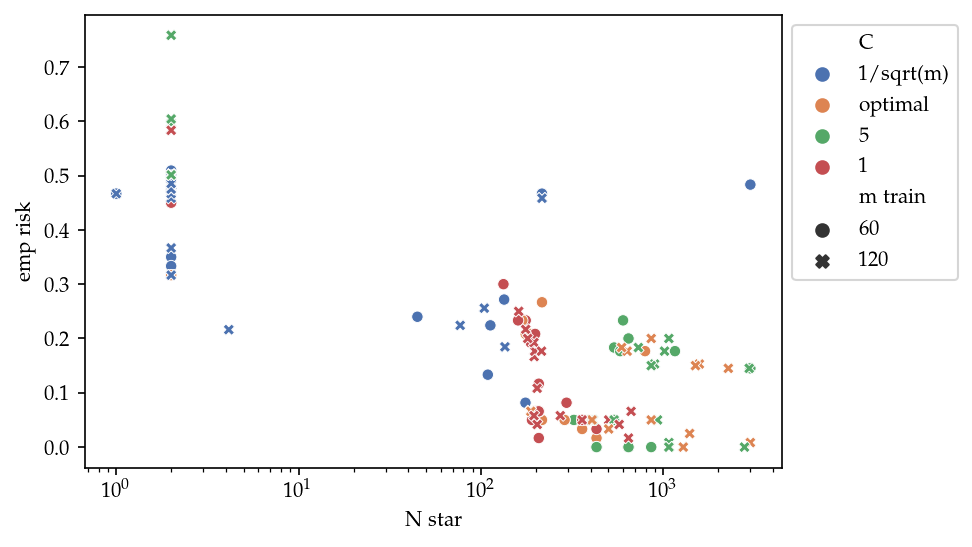

In [52]:
sns.scatterplot(data =  data,
x= "N star", y="emp risk", palette="deep", style = "m train", hue =  "C", s = 30)
plt.xscale("log")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [10]:
data.xs(120, level = "m_train")

,,,N_star,emp_risk
"kernel,dataset",Remp_eps,C,,
"(Havliscek, Generated)","(margin, 0.5)",1/sqrt(m),216.000000,0.458333
"(QAOA, Checkerboard)","(margin, 0.5)",5,2.000000,0.583333
"(Circ-Hubr, Two_Moons)","(margin, 0.5)",5,1072.000000,0.200000
"(Havliscek, Checkerboard)","(relative, 0.05)",1/sqrt(m),2.000000,0.501250
"(QAOA, Generated)","(relative, 0.05)",1/sqrt(m),2.000000,0.485417
"(Havliscek, Two_Moons)","(margin, 0.5)",1/sqrt(m),2.000000,0.316667
"(Circ-Hubr, Two_Moons)","(relative, 0.05)",5,2957.000000,0.145000
"(QAOA, Two_Moons)","(margin, 0.5)",5,1072.000000,0.008333
"(Havliscek, Generated)","(relative, 0.05)",1/sqrt(m),2.000000,0.485417
